# Preprocessing

In [1]:
import argparse
import glob
import os
import json
import time
import logging
import random
import re
from itertools import chain
from string import punctuation

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl


from transformers import (
    AdamW,
    MT5ForConditionalGeneration,
    T5ForConditionalGeneration,
    T5Tokenizer,
    AutoTokenizer,
    get_linear_schedule_with_warmup
)

os.chdir('..')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [1]:
short2long = {'ALG': 'Algorithm', 'APP': 'Application', 'CB': 'Class', 'CLA': 'Code_Block', 'DEV': 'Data_Structure', 'DS': 'Data_Type', 'DT': 'Device', 'FN': 'File_Name', 'FT': 'File_Type', 'FUN': 'Function', 'HXT': 'HTML_XML_Tag', 'LAN': 'Language', 'LIB': 'Library', 'OS': 'Operating_System', 'UIE': 'User_Interface_Element', 'UN': 'User_Name', 'VAL': 'Value', 'VAR': 'Variable', 'VER': 'Version', 'WEB': 'Website'}
labels_short = ['ALG', 'APP', 'CB', 'CLA', 'DEV', 'DS', 'DT', 'FN', 'FT', 'FUN', 'HXT', 'LAN', 'LIB', 'OS', 'UIE', 'UN', 'VAL', 'VAR', 'VER', 'WEB']
label2id = {'O': 0, 'B-ALG': 1, 'I-ALG': 2, 'B-APP': 3, 'I-APP': 4, 'B-CB': 5, 'I-CB': 6, 'B-CLA': 7, 'I-CLA': 8, 'B-DEV': 9, 'I-DEV': 10, 'B-DS': 11, 'I-DS': 12, 'B-DT': 13, 'I-DT': 14, 'B-FN': 15, 'I-FN': 16, 'B-FT': 17, 'I-FT': 18, 'B-FUN': 19, 'I-FUN': 20, 'B-HXT': 21, 'I-HXT': 22, 'B-LAN': 23, 'I-LAN': 24, 'B-LIB': 25, 'I-LIB': 26, 'B-OS': 27, 'I-OS': 28, 'B-UIE': 29, 'I-UIE': 30, 'B-UN': 31, 'I-UN': 32, 'B-VAL': 33, 'I-VAL': 34, 'B-VAR': 35, 'I-VAR': 36, 'B-VER': 37, 'I-VER': 38, 'B-WEB': 39, 'I-WEB': 40}


In [3]:
import torch
from torch.utils.data import DataLoader
from transformers import T5ForConditionalGeneration, AutoTokenizer, AdamW, get_linear_schedule_with_warmup
import pytorch_lightning as pl

class T5FineTuner(pl.LightningModule):
    def __init__(self, hparam):
        super(T5FineTuner, self).__init__()
        self.hparam = hparam

        self.model = T5ForConditionalGeneration.from_pretrained(
            hparam.model_name_or_path)
        self.tokenizer = AutoTokenizer.from_pretrained(
            hparam.model_name_or_path
        )
        self.save_hyperparameters()

    def is_logger(self):
        return True

    def forward(
        self, input_ids, attention_mask=None, decoder_input_ids=None, decoder_attention_mask=None, labels=None
    ):
        return self.model(
            input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
            labels=labels,
        )

    def _step(self, batch):
        labels = batch["target_ids"]
        labels[labels[:, :] == self.tokenizer.pad_token_id] = -100

        outputs = self(
            input_ids=batch["source_ids"],
            attention_mask=batch["source_mask"],
            labels=labels,
            decoder_attention_mask=batch['target_mask']
        )

        loss = outputs.loss

        return loss

    def training_step(self, batch, batch_idx):
        loss = self._step(batch)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._step(batch)
        self.log("val_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = AdamW(self.model.parameters(), lr=self.hparam.learning_rate, eps=self.hparam.adam_epsilon)
        t_total = (
            (len(self.train_dataloader().dataset) //
             (self.hparam.train_batch_size * max(1, self.hparam.n_gpu)))
            // self.hparam.gradient_accumulation_steps
            * float(self.hparam.num_train_epochs)
        )
        scheduler = get_linear_schedule_with_warmup(
            optimizer, num_warmup_steps=self.hparam.warmup_steps, num_training_steps=t_total
        )

        scheduler_config = {
            'scheduler': scheduler,
            'interval': 'step',
            'frequency': 1
        }
        return [optimizer], [scheduler_config]

    def train_dataloader(self):
        train_dataset = get_dataset(
            tokenizer=self.tokenizer, type_path="train", args=self.hparam)
        return DataLoader(train_dataset, batch_size=self.hparam.train_batch_size,
                          drop_last=True, shuffle=True, num_workers=2)

    def val_dataloader(self):
        val_dataset = get_dataset(
            tokenizer=self.tokenizer, type_path="validation", args=self.hparam)
        return DataLoader(val_dataset, batch_size=self.hparam.eval_batch_size, num_workers=2)


In [4]:
class MyDataset(Dataset):
  def __init__(self, tokenizer, dataset, type_path, max_len=512):

    self.data = dataset[type_path]
    self.max_len = max_len
    self.tokenizer = tokenizer
    self.tokenizer.max_length = max_len
    self.tokenizer.model_max_length = max_len
    self.inputs = []
    self.targets = []

    self._build()

  def __len__(self):
    return len(self.inputs)

  def __getitem__(self, index):
    source_ids = self.inputs[index]["input_ids"].squeeze()
    target_ids = self.targets[index]["input_ids"].squeeze()

    src_mask    = self.inputs[index]["attention_mask"].squeeze()  # might need to squeeze
    target_mask = self.targets[index]["attention_mask"].squeeze()  # might need to squeeze

    return {"source_ids": source_ids, "source_mask": src_mask, "target_ids": target_ids, "target_mask": target_mask}

  def _build(self):
    for idx in range(len(self.data)):
      input_, target = " ".join(self.data[idx]["tokens"]), "; ".join(self.data[idx]["spans"])

      input_ = input_.lower() + ' </s>'
      target = target.lower() + " </s>"

       # tokenize inputs
      tokenized_inputs = self.tokenizer.batch_encode_plus(
          [input_], max_length=self.max_len, padding="max_length", truncation=True, return_tensors="pt"
      )
       # tokenize targets
      tokenized_targets = self.tokenizer.batch_encode_plus(
          [target],max_length=self.max_len, padding="max_length", truncation=True, return_tensors="pt"
      )

      self.inputs.append(tokenized_inputs)
      self.targets.append(tokenized_targets)

In [5]:
from datasets import load_dataset

path = "../data/StackOverflow/json/"

dataset = load_dataset('json', data_files=os.path.join(path, 'data_train.json'))
dataset["test"] = load_dataset('json', data_files=os.path.join(path, 'data_test.json'))["train"]
dataset["validation"] = load_dataset('json', data_files=os.path.join(path, 'data_dev.json'))["train"]

model_code = T5FineTuner.load_from_checkpoint("lightning_logs/version_9/codet5-small-t2t.ckpt")
tokenizer_code = AutoTokenizer.from_pretrained("Salesforce/codet5-small")

model = T5FineTuner.load_from_checkpoint("lightning_logs/version_14/t5-small-t2t.ckpt")
tokenizer = AutoTokenizer.from_pretrained("t5-small")

In [6]:
def find_sub_list(sl, l):
    results = []
    sll = len(sl)
    for ind in (i for i, e in enumerate(l) if e == sl[0]):
        if l[ind:ind+sll] == sl:
            results.append((ind, ind+sll-1))
    return results

def generate_label(input: str, target: str):
    mapper = {'O': 0, 'B-ALG': 1, 'I-ALG': 2, 'B-APP': 3, 'I-APP': 4, 'B-CB': 5, 'I-CB': 6, 'B-CLA': 7, 'I-CLA': 8, 'B-DEV': 9, 'I-DEV': 10, 'B-DS': 11, 'I-DS': 12, 'B-DT': 13, 'I-DT': 14, 'B-FN': 15, 'I-FN': 16, 'B-FT': 17, 'I-FT': 18, 'B-FUN': 19, 'I-FUN': 20, 'B-HXT': 21, 'I-HXT': 22, 'B-LAN': 23, 'I-LAN': 24, 'B-LIB': 25, 'I-LIB': 26, 'B-OS': 27, 'I-OS': 28, 'B-UIE': 29, 'I-UIE': 30, 'B-UN': 31, 'I-UN': 32, 'B-VAL': 33, 'I-VAL': 34, 'B-VAR': 35, 'I-VAR': 36, 'B-VER': 37, 'I-VER': 38, 'B-WEB': 39, 'I-WEB': 40}

    inv_mapper = {v: k for k, v in mapper.items()}

    input = input.split(" ")
    target = target.split("; ")

    init_target_label = [mapper['O']]*len(input)

    for ent in target:
        ent = ent.split(": ")
        try:
            sent_end = ent[1].split(" ")
            index = find_sub_list(sent_end, input)
        except:
            continue
        # print(index)
        try:
            init_target_label[index[0][0]] = mapper[f"B-{ent[0].upper()}"]
            for i in range(index[0][0]+1, index[0][1]+1):
                init_target_label[i] = mapper[f"I-{ent[0].upper()}"]
        except:
            continue
    init_target_label = [inv_mapper[j] for j in init_target_label]
    return init_target_label

In [7]:
from tqdm import tqdm

def make_prediction(model, tokenizer, dataset, type_path):
    test_dataset = MyDataset(tokenizer=tokenizer, dataset=dataset, type_path=type_path)
    test_loader = DataLoader(test_dataset, batch_size=32, num_workers=2, shuffle=True)

    model.model.eval()
    model = model.to("cuda")

    all_text = []
    true_labels = []
    pred_labels = []
    for batch in tqdm(test_loader):
        input_ids = batch['source_ids'].to("cuda")
        attention_mask = batch['source_mask'].to("cuda")
        outs = model.model.generate(input_ids=input_ids,
                                    attention_mask=attention_mask)
        dec = [tokenizer.decode(ids, skip_special_tokens=True,
                                clean_up_tokenization_spaces=False).strip() for ids in outs]
        target = [tokenizer.decode(ids, skip_special_tokens=True,  clean_up_tokenization_spaces=False).strip()
                    for ids in batch["target_ids"]]
        texts = [tokenizer.decode(ids, skip_special_tokens=True,  clean_up_tokenization_spaces=False).strip()
                    for ids in batch["source_ids"]]
        true_label = [generate_label(texts[i].strip(), target[i].strip()) if target[i].strip() != 'none' else [
            "O"]*len(texts[i].strip().split()) for i in range(len(texts))]
        pred_label = [generate_label(texts[i].strip(), dec[i].strip()) if dec[i].strip() != 'none' else [
            "O"]*len(texts[i].strip().split()) for i in range(len(texts))]

        true_labels.extend(true_label)
        pred_labels.extend(pred_label)
        all_text.extend(texts)
    return true_labels, pred_labels, all_text

In [8]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels



def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    fig, ax = plt.subplots(figsize =(20, 20))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Results

In [ ]:
from datasets import load_metric

metric = load_metric("seqeval")

true, pred, _ = make_prediction(model, tokenizer, dataset, "test")
true_code, pred_code, _ = make_prediction(model_code, tokenizer_code, dataset, "test")
# conf_true_test = []
# for x in true:
#     conf_true_test.extend(x)

# conf_pred_test = []
# for x in pred:
#     conf_pred_test.extend(x)

dct_test = metric.compute(predictions=pred, references=true)
dct_code_test = metric.compute(predictions=pred_code, references=true_code)

true, pred, _ = make_prediction(model, tokenizer, dataset, "validation")
true_code, pred_code, _ = make_prediction(model_code, tokenizer_code, dataset, "validation")

# conf_true_val = []
# for x in true:
#     conf_true_val.extend(x)

# conf_pred_val = []
# for x in pred:
#     conf_pred_val.extend(x)

dct_val = metric.compute(predictions=pred, references=true)
dct_code_val = metric.compute(predictions=pred_code, references=true_code)

## Validation set

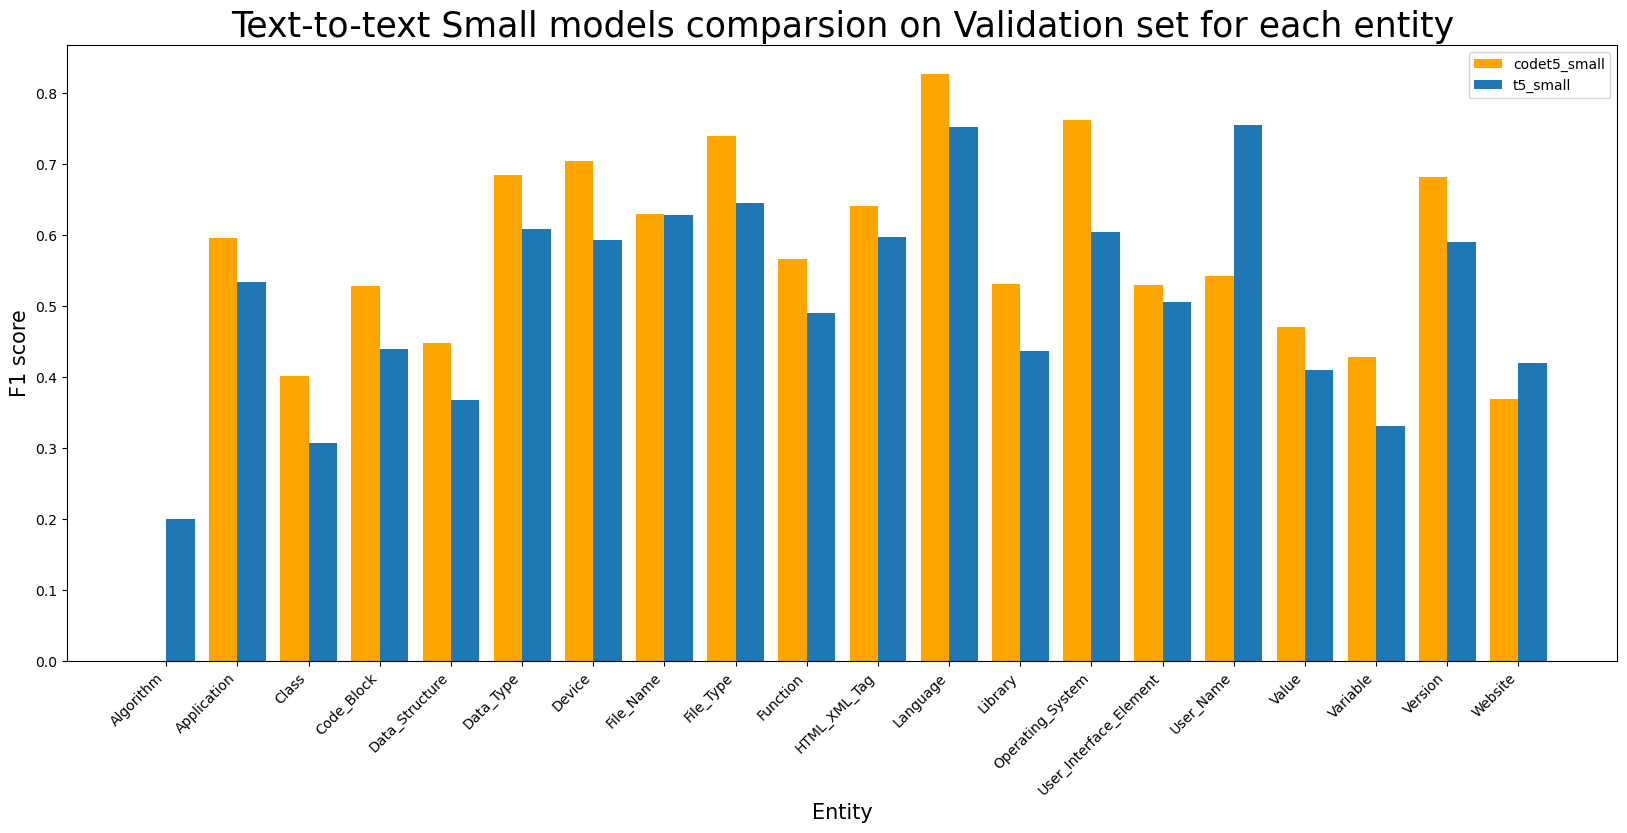

In [10]:
import matplotlib.pyplot as plt

barWidth = 0.2
fig = plt.subplots(figsize =(20, 8))

dct_arr = {x: dct_val[x]["f1"] for x in dct_val if "overall" not in x}
dct_arr_code = {x: dct_code_val[x]["f1"] for x in dct_code_val if "overall" not in x}

X = [short2long[x] for x in dct_arr.keys()]
X_axis = np.arange(len(X))

plt.bar(X_axis - barWidth, list(dct_arr_code.values()), color="orange", width=barWidth*2, label ='codet5_small')
plt.bar(X_axis + barWidth, list(dct_arr.values()),  width=barWidth*2, label ='t5_small')

plt.title('Text-to-text Small models comparsion on Validation set for each entity', fontsize = 25)
plt.xlabel('Entity', fontsize = 15)
plt.ylabel('F1 score', fontsize = 15) 
plt.xticks(X_axis, X, rotation=45, ha='right')
plt.legend()
plt.show()

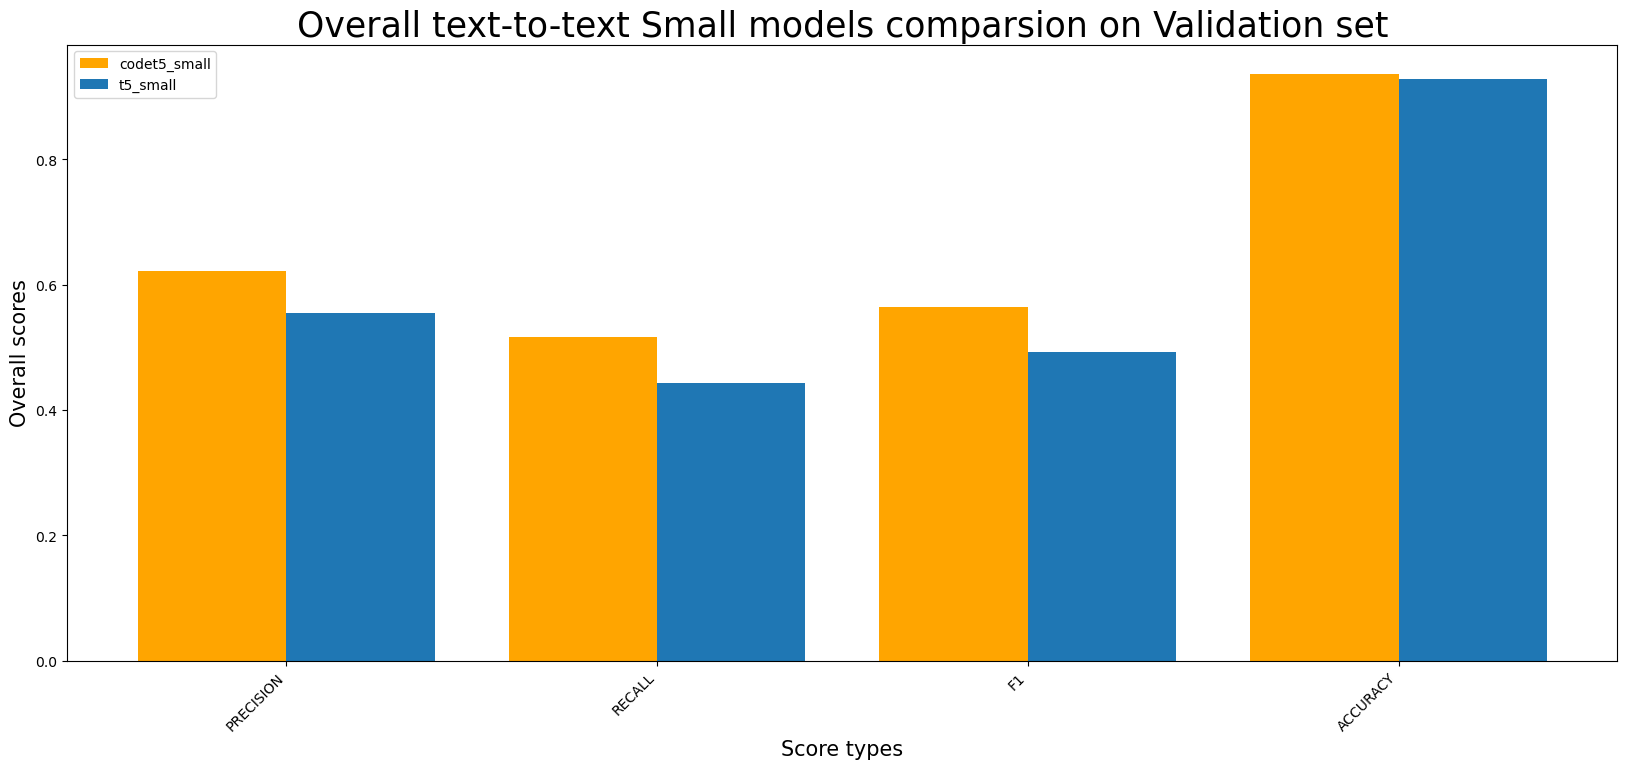

In [11]:
import matplotlib.pyplot as plt

barWidth = 0.2
fig = plt.subplots(figsize =(20, 8))

dct_arr = {x: dct_val[x] for x in dct_val if "overall" in x}
dct_arr_code = {x: dct_code_val[x] for x in dct_code_val if "overall" in x}

X = [x.split("_")[1].upper() for x in dct_arr.keys() if "overall" in x]
X_axis = np.arange(len(X))

plt.bar(X_axis - barWidth, list(dct_arr_code.values()), color="orange", width=barWidth*2, label="codet5_small")
plt.bar(X_axis + barWidth, list(dct_arr.values()),  width=barWidth*2, label="t5_small")

plt.title('Overall text-to-text Small models comparsion on Validation set', fontsize = 25)
plt.xlabel('Score types', fontsize = 15)
plt.ylabel('Overall scores', fontsize = 15) 
plt.xticks(X_axis, X, rotation=45, ha='right')
plt.legend()
plt.show()

In [12]:
print(f"F1 scores on VALIDATION set:\n\nt5-small - {dct_val['overall_f1']}\ncodet5-small - {dct_code_val['overall_f1']}")

F1 scores on VALIDATION set:

t5-small - 0.4922536336048555
codet5-small - 0.5643440050219711


Confusion matrix, without normalization


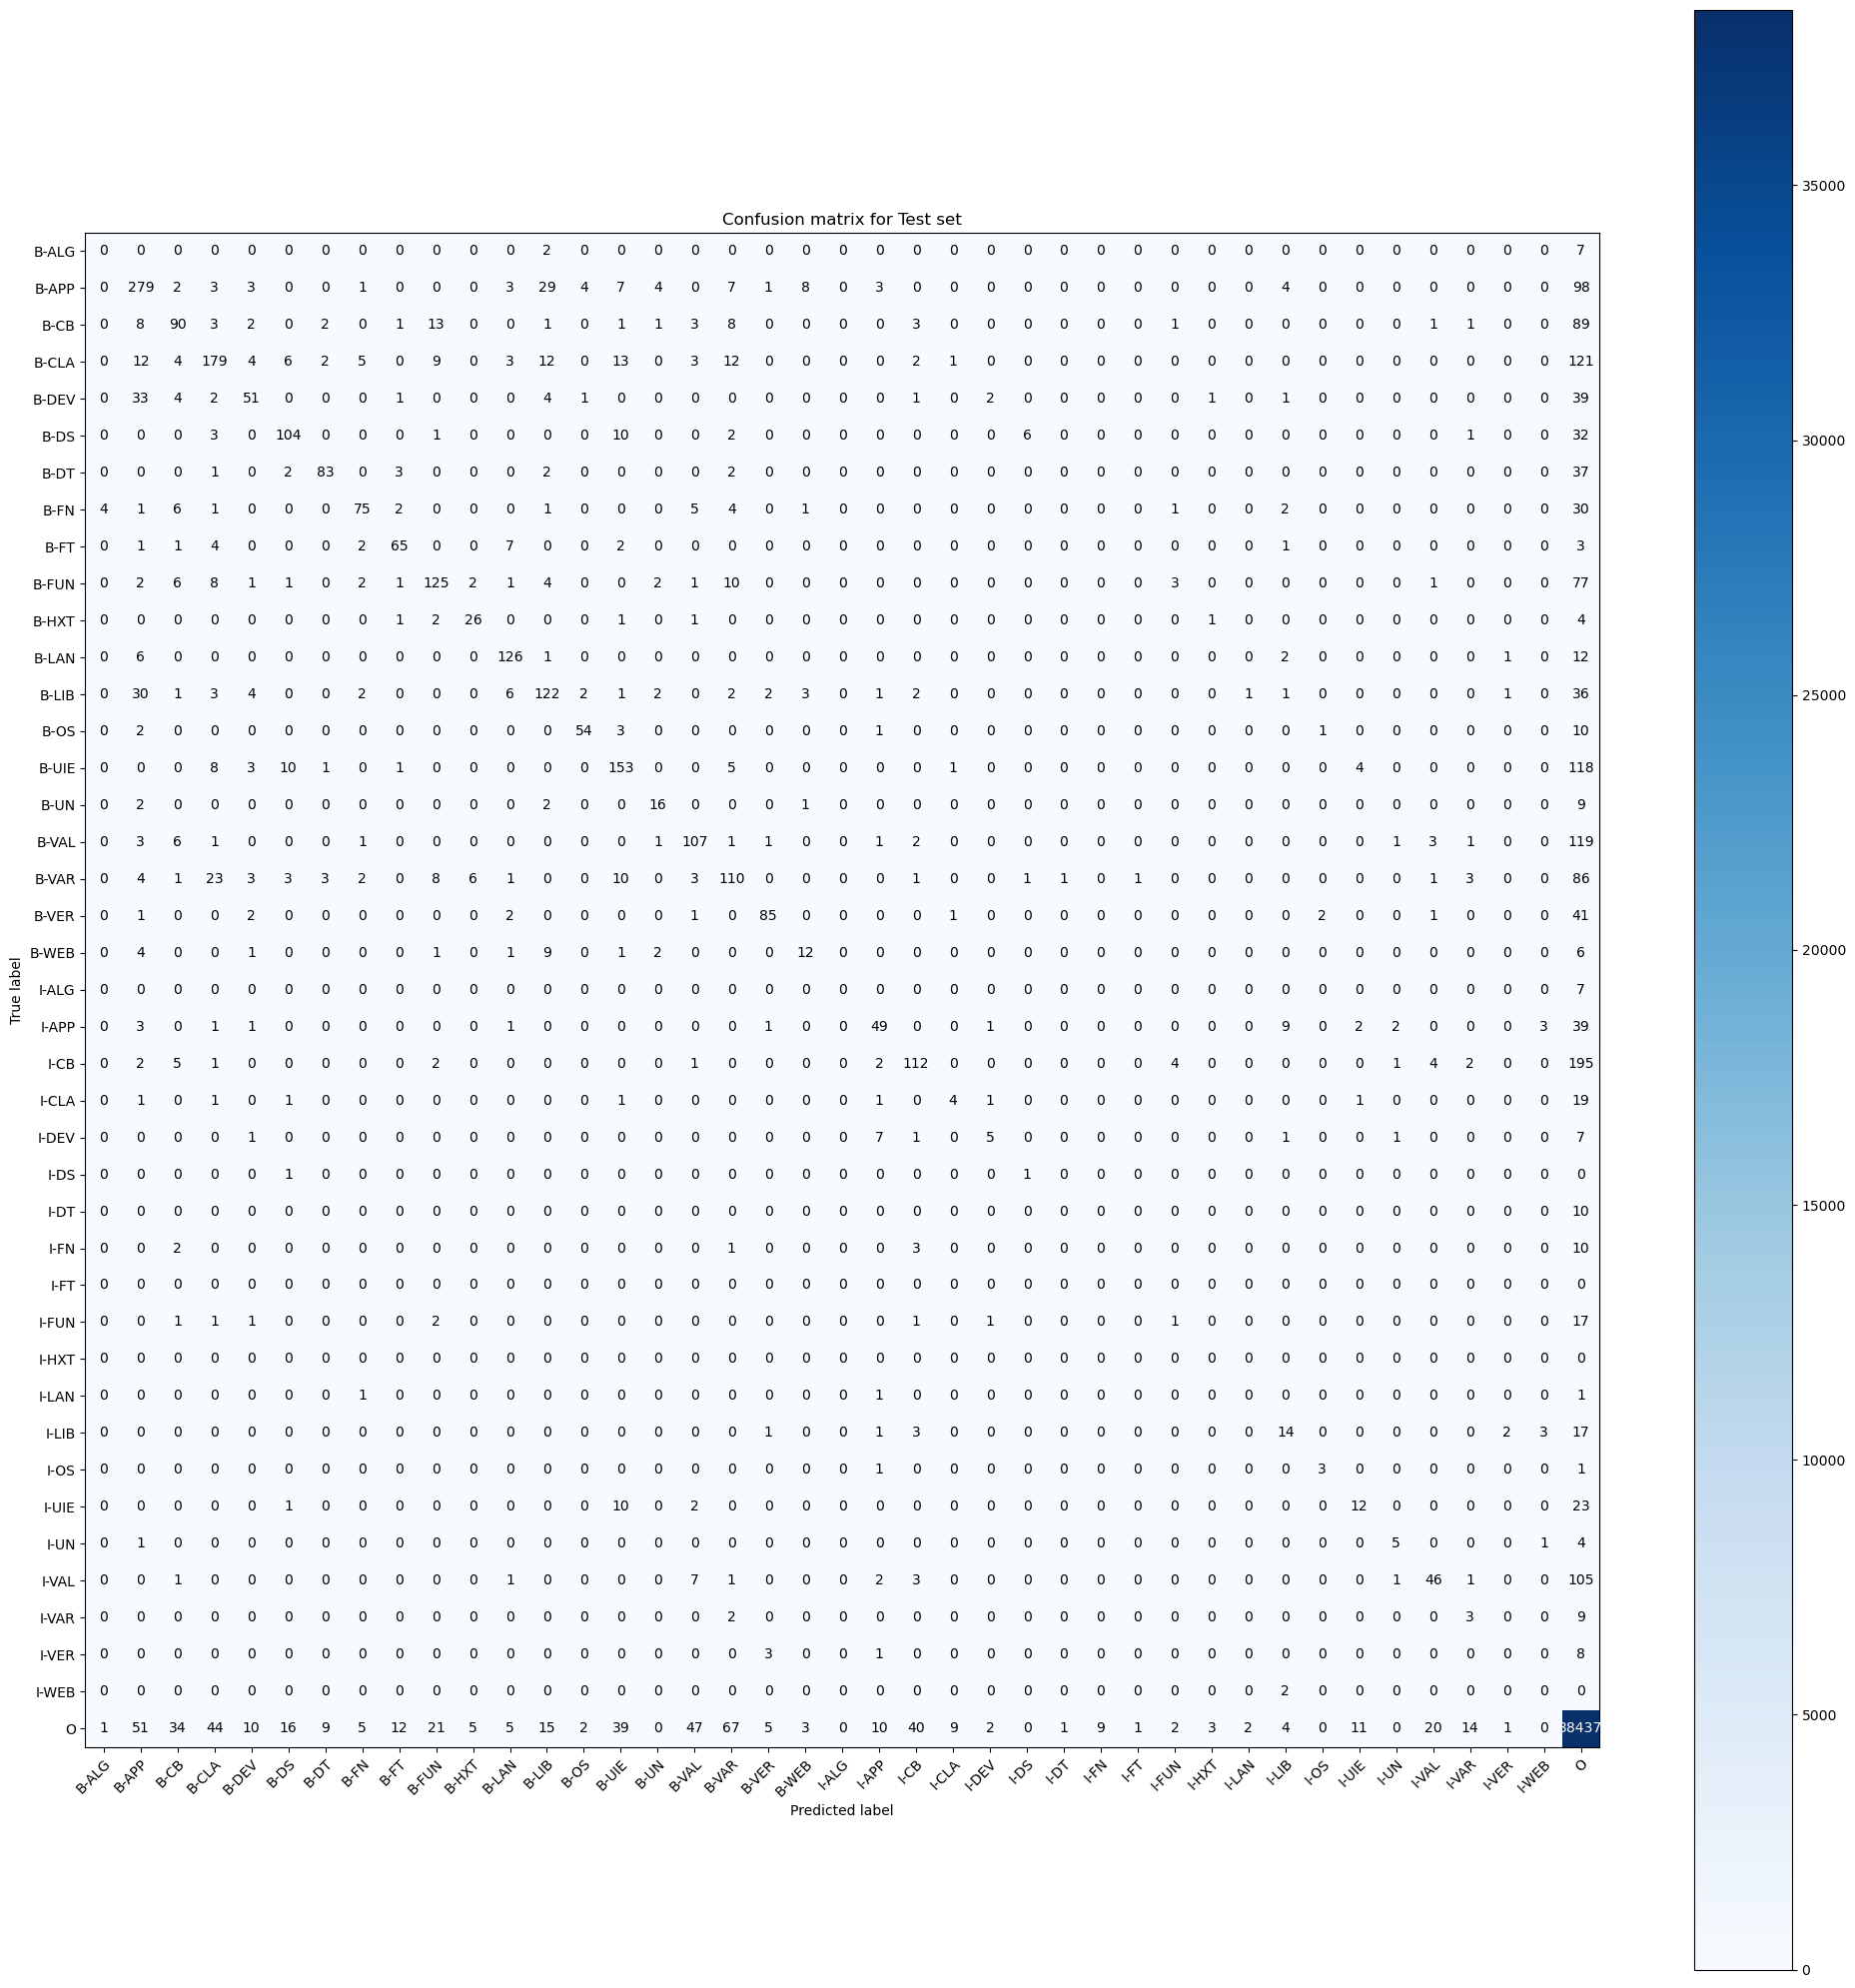

In [13]:
conf_true_val = []
for x in true_code:
    conf_true_val.extend(x)

conf_pred_val = []
for x in pred_code:
    conf_pred_val.extend(x)

plot_confusion_matrix(conf_true_val, conf_pred_val, classes=None,
                      title='Confusion matrix for Test set')
plt.show()

In [14]:
dct_code_val

{'ALG': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 9},
 'APP': {'precision': 0.6017897091722595,
  'recall': 0.5886214442013129,
  'f1': 0.5951327433628318,
  'number': 457},
 'CB': {'precision': 0.4817073170731707,
  'recall': 0.34347826086956523,
  'f1': 0.401015228426396,
  'number': 230},
 'CLA': {'precision': 0.6202090592334495,
  'recall': 0.4587628865979381,
  'f1': 0.5274074074074074,
  'number': 388},
 'DEV': {'precision': 0.5862068965517241,
  'recall': 0.3617021276595745,
  'f1': 0.4473684210526315,
  'number': 141},
 'DS': {'precision': 0.7172413793103448,
  'recall': 0.6540880503144654,
  'f1': 0.6842105263157895,
  'number': 159},
 'DT': {'precision': 0.81,
  'recall': 0.6230769230769231,
  'f1': 0.7043478260869566,
  'number': 130},
 'FN': {'precision': 0.75,
  'recall': 0.5413533834586466,
  'f1': 0.62882096069869,
  'number': 133},
 'FT': {'precision': 0.735632183908046,
  'recall': 0.7441860465116279,
  'f1': 0.7398843930635838,
  'number': 86},
 'FUN': {'

## Test set

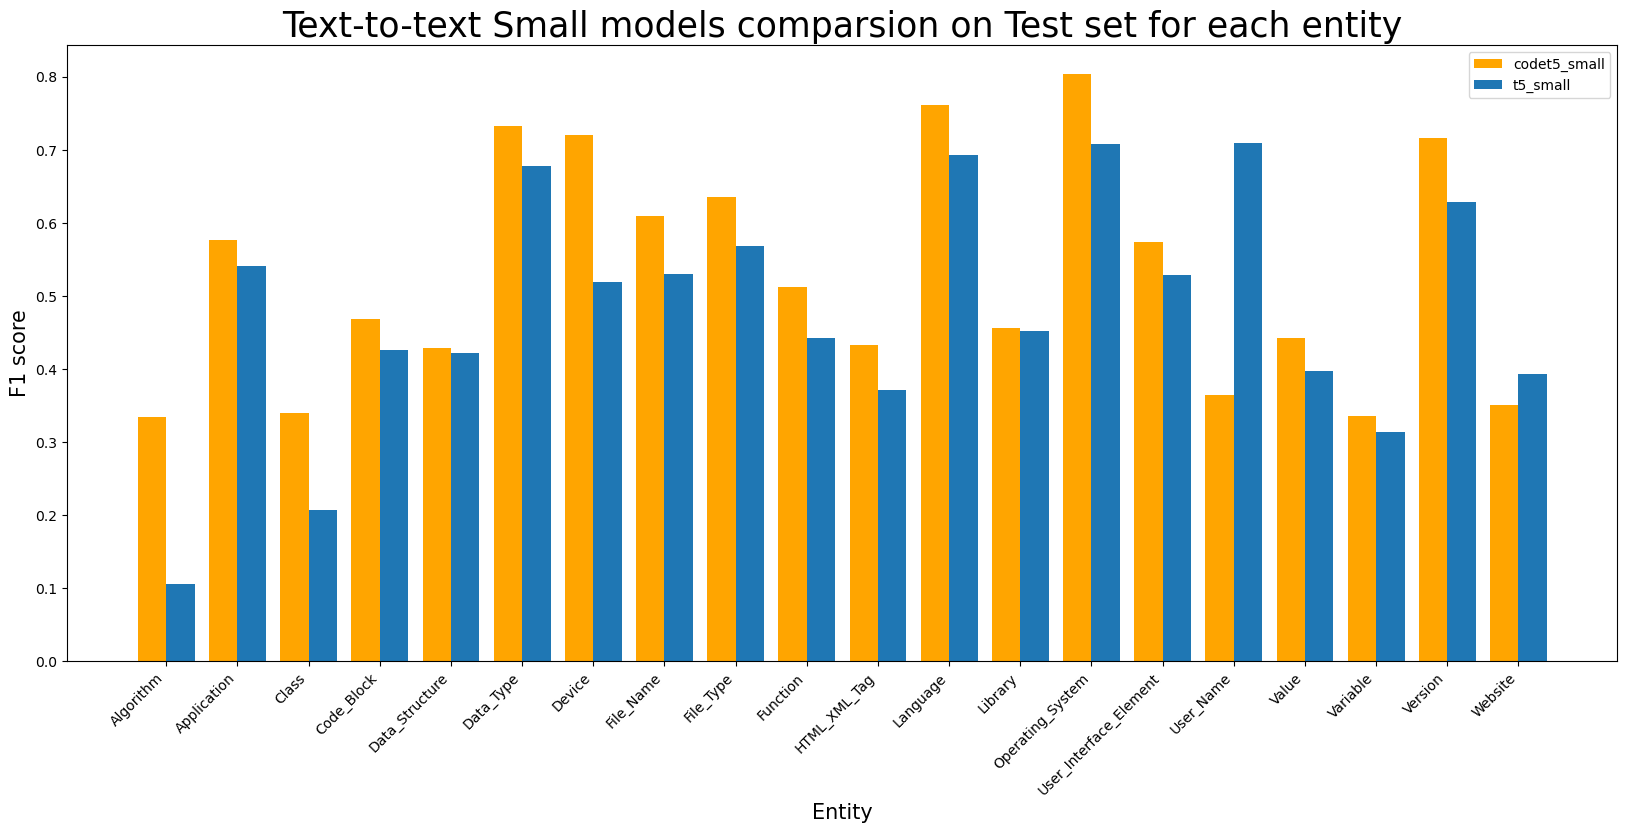

In [15]:
import matplotlib.pyplot as plt

barWidth = 0.2
fig = plt.subplots(figsize =(20, 8))

dct_arr = {x: dct_test[x]["f1"] for x in dct_test if "overall" not in x}
dct_arr_code = {x: dct_code_test[x]["f1"] for x in dct_code_test if "overall" not in x}

X = [short2long[x] for x in dct_arr.keys()]
X_axis = np.arange(len(X))

plt.bar(X_axis - barWidth, list(dct_arr_code.values()), color="orange", width=barWidth*2, label ='codet5_small')
plt.bar(X_axis + barWidth, list(dct_arr.values()),  width=barWidth*2, label ='t5_small')

plt.title('Text-to-text Small models comparsion on Test set for each entity', fontsize = 25)
plt.xlabel('Entity', fontsize = 15)
plt.ylabel('F1 score', fontsize = 15) 
plt.xticks(X_axis, X, rotation=45, ha='right')
plt.legend()
plt.show()

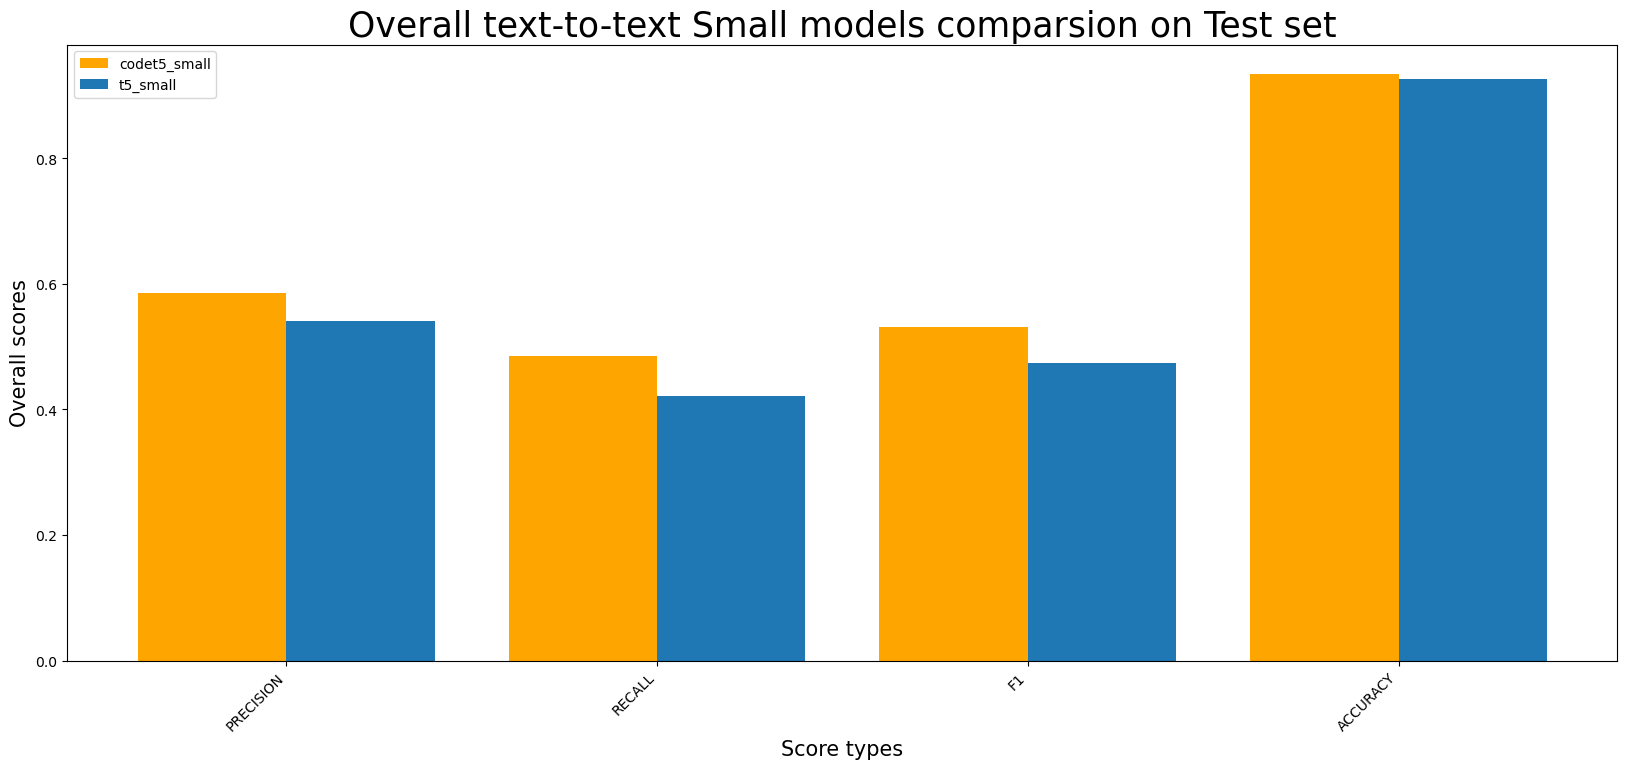

In [16]:
import matplotlib.pyplot as plt

barWidth = 0.2
fig = plt.subplots(figsize =(20, 8))

dct_arr = {x: dct_test[x] for x in dct_test if "overall" in x}
dct_arr_code = {x: dct_code_test[x] for x in dct_code_test if "overall" in x}

X = [x.split("_")[1].upper() for x in dct_arr.keys() if "overall" in x]
X_axis = np.arange(len(X))

plt.bar(X_axis - barWidth, list(dct_arr_code.values()), color="orange", width=barWidth*2, label="codet5_small")
plt.bar(X_axis + barWidth, list(dct_arr.values()),  width=barWidth*2, label="t5_small")

plt.title('Overall text-to-text Small models comparsion on Test set', fontsize = 25)
plt.xlabel('Score types', fontsize = 15)
plt.ylabel('Overall scores', fontsize = 15) 
plt.xticks(X_axis, X, rotation=45, ha='right')
plt.legend()
plt.show()

In [17]:
print(f"F1 scores on TEST set:\n\nt5-small - {dct_test['overall_f1']}\ncodet5-small - {dct_code_test['overall_f1']}")

F1 scores on TEST set:

t5-small - 0.4738527214514408
codet5-small - 0.530745295599348


# Domain adaptation

In [20]:
import datasets
datasets.builder.has_sufficient_disk_space = lambda needed_bytes, directory='.': True


path = "../data/GitHub/"

dataset = load_dataset('json', data_files=os.path.join(path, 'data_gh.json'))

Generating train split: 0 examples [00:00, ? examples/s]

In [22]:
true, pred, _ = make_prediction(model, tokenizer, dataset, "train")
true_code, pred_code, _ = make_prediction(model_code, tokenizer_code, dataset, "train")
# conf_true_test = []
# for x in true:
#     conf_true_test.extend(x)

# conf_pred_test = []
# for x in pred:
#     conf_pred_test.extend(x)

dct_gh = metric.compute(predictions=pred, references=true)
dct_code_gh = metric.compute(predictions=pred_code, references=true_code)

  0%|          | 0/251 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  0%|          | 0/251 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environme

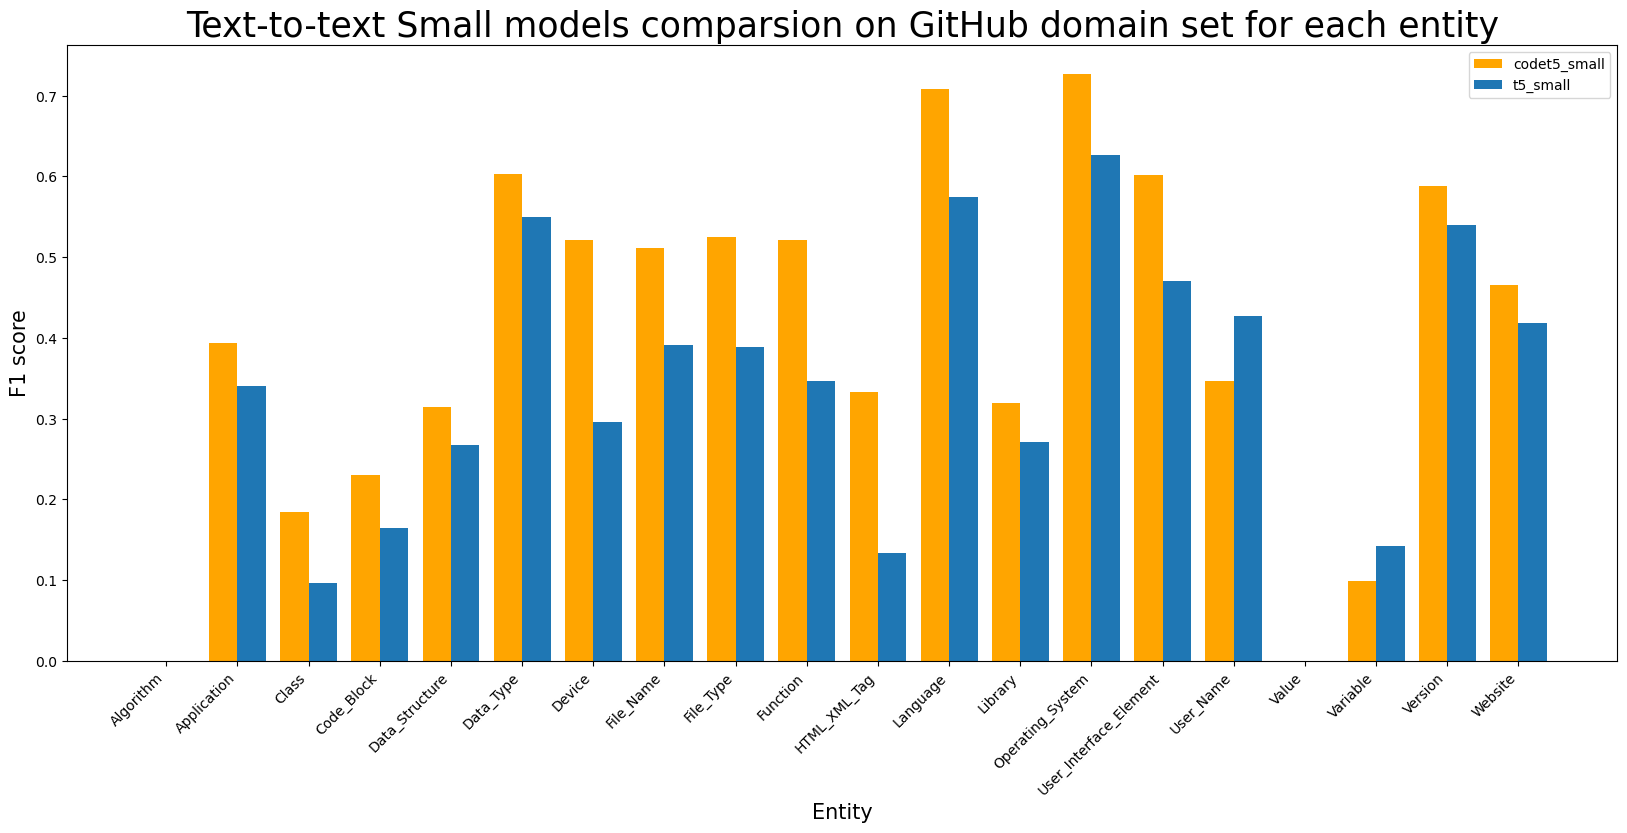

In [23]:
import matplotlib.pyplot as plt

barWidth = 0.2
fig = plt.subplots(figsize =(20, 8))

dct_arr = {x: dct_gh[x]["f1"] for x in dct_gh if "overall" not in x}
dct_arr_code = {x: dct_code_gh[x]["f1"] for x in dct_code_gh if "overall" not in x}

X = [short2long[x] for x in dct_arr.keys()]
X_axis = np.arange(len(X))

plt.bar(X_axis - barWidth, list(dct_arr_code.values()), color="orange", width=barWidth*2, label ='codet5_small')
plt.bar(X_axis + barWidth, list(dct_arr.values()),  width=barWidth*2, label ='t5_small')

plt.title('Text-to-text Small models comparsion on GitHub domain set for each entity', fontsize = 25)
plt.xlabel('Entity', fontsize = 15)
plt.ylabel('F1 score', fontsize = 15) 
plt.xticks(X_axis, X, rotation=45, ha='right')
plt.legend()
plt.show()

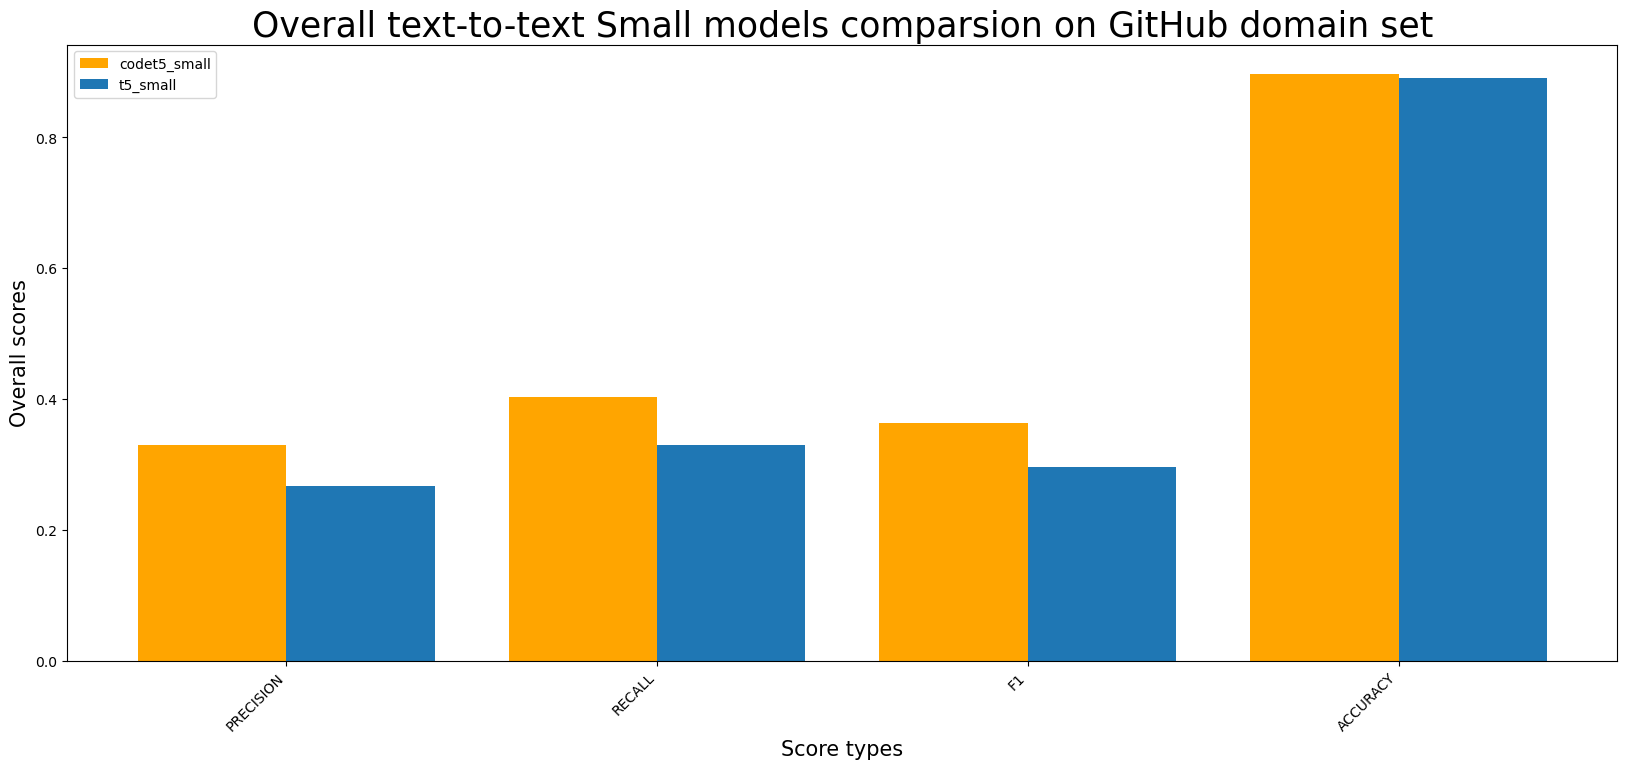

In [24]:
import matplotlib.pyplot as plt

barWidth = 0.2
fig = plt.subplots(figsize =(20, 8))

dct_arr = {x: dct_gh[x] for x in dct_gh if "overall" in x}
dct_arr_code = {x: dct_code_gh[x] for x in dct_code_gh if "overall" in x}

X = [x.split("_")[1].upper() for x in dct_arr.keys() if "overall" in x]
X_axis = np.arange(len(X))

plt.bar(X_axis - barWidth, list(dct_arr_code.values()), color="orange", width=barWidth*2, label="codet5_small")
plt.bar(X_axis + barWidth, list(dct_arr.values()),  width=barWidth*2, label="t5_small")

plt.title('Overall text-to-text Small models comparsion on GitHub domain set', fontsize = 25)
plt.xlabel('Score types', fontsize = 15)
plt.ylabel('Overall scores', fontsize = 15) 
plt.xticks(X_axis, X, rotation=45, ha='right')
plt.legend()
plt.show()

In [25]:
print(f"F1 scores on GitHub domain set:\n\nt5-small - {dct_gh['overall_f1']}\ncodet5-small - {dct_code_gh['overall_f1']}")

F1 scores on GitHub domain set:

t5-small - 0.29521792835715543
codet5-small - 0.36247561624401486
